# Integrator RNN Model

In this notebook, we train a vanilla RNN to integrate white noise. This example is useful on its own to understand how RNN training works.

In [1]:
from functools import partial
import matplotlib.pyplot as plt

import brainpy as bp
import brainpy.math as bm

bm.set_environment(bm.training_mode)

## Parameters

In [2]:
dt = 0.04
num_step = int(1.0 / dt)
num_batch = 128

## Data

In [3]:
@partial(bm.jit,
         dyn_vars=bp.TensorCollector({'a': bm.random.DEFAULT}),
         static_argnames=['batch_size'])
def build_inputs_and_targets(mean=0.025, scale=0.01, batch_size=10):
  # Create the white noise input
  sample = bm.random.normal(size=(batch_size, 1, 1))
  bias = mean * 2.0 * (sample - 0.5)
  samples = bm.random.normal(size=(batch_size, num_step, 1))
  noise_t = scale / dt ** 0.5 * samples
  inputs = bias + noise_t
  targets = bm.cumsum(inputs, axis=1)
  return inputs, targets

In [4]:
def train_data():
  for _ in range(100):
    yield build_inputs_and_targets(batch_size=num_batch)

## Model

In [5]:
class RNN(bp.DynamicalSystem):
  def __init__(self, num_in, num_hidden):
    super(RNN, self).__init__()
    self.rnn = bp.layers.RNNCell(num_in, num_hidden, train_state=True)
    self.out = bp.layers.Dense(num_hidden, 1)

  def update(self, sha, x):
    return self.out(sha, self.rnn(sha, x))

model = RNN(1, 100)

## Training

In [6]:
# define loss function
def loss(predictions, targets, l2_reg=2e-4):
  mse = bp.losses.mean_squared_error(predictions, targets)
  l2 = l2_reg * bp.losses.l2_norm(model.train_vars().unique().dict()) ** 2
  return mse + l2


# define optimizer
lr = bp.optim.ExponentialDecay(lr=0.025, decay_steps=1, decay_rate=0.99975)
opt = bp.optim.Adam(lr=lr, eps=1e-1)


# create a trainer
trainer = bp.BPTT(model, loss_fun=loss, optimizer=opt)
trainer.fit(train_data,
            num_epoch=30,
            num_report=200)

Train 200 steps, use 2.0416 s, loss 0.43417808413505554
Train 400 steps, use 1.1465 s, loss 0.027894824743270874
Train 600 steps, use 1.1387 s, loss 0.02194945327937603
Train 800 steps, use 4.5845 s, loss 0.021538913249969482
Train 1000 steps, use 5.0299 s, loss 0.02128899097442627
Train 1200 steps, use 4.9541 s, loss 0.02115160971879959
Train 1400 steps, use 5.0622 s, loss 0.021017059683799744
Train 1600 steps, use 5.0935 s, loss 0.020916711539030075
Train 1800 steps, use 4.9851 s, loss 0.020782889798283577
Train 2000 steps, use 4.8506 s, loss 0.020689304918050766
Train 2200 steps, use 5.1480 s, loss 0.020607156679034233
Train 2400 steps, use 5.0867 s, loss 0.020528702065348625
Train 2600 steps, use 4.9022 s, loss 0.02044598013162613
Train 2800 steps, use 4.8018 s, loss 0.020371917635202408
Train 3000 steps, use 4.9188 s, loss 0.020304910838603973


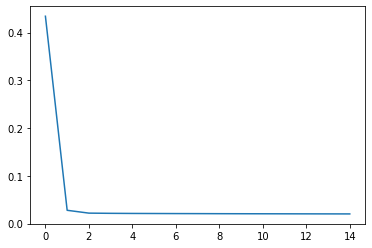

In [7]:
plt.plot(bm.as_numpy(trainer.get_hist_metric()))
plt.show()

## Testing

  0%|          | 0/25 [00:00<?, ?it/s]

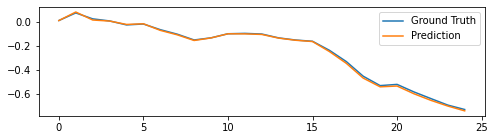

In [8]:
model.reset_state(1)
x, y = build_inputs_and_targets(batch_size=1)
predicts = trainer.predict(x)

plt.figure(figsize=(8, 2))
plt.plot(bm.as_numpy(y[0]).flatten(), label='Ground Truth')
plt.plot(bm.as_numpy(predicts[0]).flatten(), label='Prediction')
plt.legend()
plt.show()